# CpE Elective 3 Laboratory (LBYCPC4) <br/>
#### Computer Vision and Deep Learning Elective Track
<br/>
<hr style="border:5px solid gray">


## Activity 3: Applications of Image Generation Models

### Introduction
&emsp;&emsp;&emsp;Image generation models have become a pivotal area of research in machine learning and deep learning. These models have the ability to create realistic, high-quality images from scratch, often mimicking the style, structure, or content of real-world images. In this activity, you are going to explore additional GAN models to generate images.

Generative adversarial networks generate images based purely on random noise, which means the user has little control over what type of image is generated. On the other hand, Conditional GANs [1] allow you to condition the image generation process on additional information, such as class labels or other data features.

Image Super-Resolution is a computer vision task that involves increasing the resolution of an image. Super-resolution GANs (SRGANs) [2] are designed to enhance the resolution and quality of images. The goal of SRGAN is to generate high-resolution images from low-resolution inputs, providing finer details and sharper images.

### Objectives
- Familiarize with the architecture of conditional GAN
- Familiarize the architecture of super-resolution GAN
- Build and train a conditional GAN image generative model using deep learning framework
- Build and train a super-resolution GAN image generative model using deep learning framework
- Visualize the output of image generation models
- Assess the performance of the implemented image generation models

### Activity

Execute the code cells below to install the required Python packages and libraries.

In [ ]:
# Install preliminary Python packages
!pip install -q tensorflow-datasets
!pip install extra-keras-datasets
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [ ]:
# Import libraries
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torchvision.transforms import ToTensor
from keras.utils import to_categorical
from torchvision import datasets

**A. Controllable Image Generation using Conditional GAN**

1. Acquire and preprocess the [EMNIST Dataset](https://www.nist.gov/itl/products-and-services/emnist-dataset). Image pixel values should be normalized and oriented properly. Display at least ten (10) training images. Execute the next code cell to define the model parameters.

100%|██████████| 561753746/561753746 [00:44<00:00, 12639299.14it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


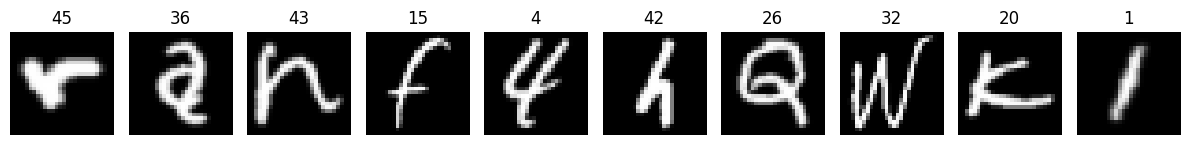

In [ ]:
# Get the EMNIST dataset
# https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html
# The dataset has to be in Tensorflow Dataset format
# Save the training data to variable ds_train
# Save the testing data to variable ds_test
# Save the dataset info to variable ds_info
# Define image size
img_size = 28
# Define the preprocessing function
# Normalize the pixel values of all images
# Label should be converted to one-hot (categorical) encoding
# Apply image preprocessing to the datasets
### --YOUR CODE HERE-- ###

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


X_train, y_train = [], []
for data in train_loader:
    img, lbl = data
    img = img.numpy().reshape(img.shape[0], img_size, img_size)
    img = np.rot90(img, k=-1, axes=(1, 2))
    img = np.flip(img, axis=2)
    X_train.append(img)
    y_train.append(lbl.numpy())

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)


X_test, y_test = [], []
for data in test_loader:
    img, lbl = data
    img = img.numpy().reshape(img.shape[0], img_size, img_size)
    img = np.rot90(img, k=-1, axes=(1, 2))
    img = np.flip(img, axis=2)
    X_test.append(img)
    y_test.append(lbl.numpy())

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)


X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = to_categorical(y_train, num_classes=47)
y_test = to_categorical(y_test, num_classes=47)


ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_info = {
    'num_classes': len(np.unique(y_train)), 'train_size': len(X_train), 'test_size': len(X_test)}


# Display 10 images from the dataset in a single row
# Each image should have a label underneath
### --YOUR CODE HERE-- ###
fig, axes = plt.subplots(1, 10, figsize=(12, 2))
for idx, (img, lbl) in zip(range(10), ds_train.take(10)):
    axes[idx].imshow(img.numpy().squeeze(), cmap='gray')
    axes[idx].set_title(np.argmax(lbl.numpy()))
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define the model paramaters
latent_dim = 128
num_classes = 47
num_channels = 1

# Define input channels for each network
discriminator_channels = num_channels + num_classes
generator_channels = latent_dim + num_classes

2. Build the initial discriminator subnetwork as suggested below. You may change the number of layers, the type, and their respective parameters as needed.
<center><img src="https://drive.google.com/uc?export=view&id=17U6iA41RRFZJpliUAC8_ryjZgnr7rgow"></center>

In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      # Import functions and classes from Keras library
from keras import Input, Sequential
from keras.layers import LeakyReLU, Dense, Dropout
from keras.layers import Conv2D, Flatten


# Create the discriminator. Save it to cgan_discriminator variable
# The input channels should be 'discriminator_channels'
# Convolution should have a filter size of 4 and a stride of 2
# You may use reasonable parameter values for LeakyReLU and Dropout layers
### --YOUR CODE HERE-- ###
# Create the discriminator model
cgan_discriminator = Sequential()

cgan_discriminator.add(Input(shape=(28, 28, discriminator_channels)))
cgan_discriminator.add(Conv2D(64, kernel_size=4, strides=2, activation='linear', padding='same'))
cgan_discriminator.add(LeakyReLU())
cgan_discriminator.add(Dropout(0.3))
cgan_discriminator.add(Conv2D(latent_dim, kernel_size=4, strides=2, activation='linear', padding='same'))
cgan_discriminator.add(LeakyReLU())
cgan_discriminator.add(Dropout(0.3))
cgan_discriminator.add(Flatten())
cgan_discriminator.add(Dense(1, activation='linear'))



cgan_discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,689 (729.25 KB)

 Trainable params: 186,689 (729.25 KB)

 Non-trainable params: 0 (0.00 B)

3. Build the initial generator subnetwork as suggested below. You may change the number of layers, the type, and their respective parameters as needed.
<center><img src="https://drive.google.com/uc?export=view&id=1t7CzW32IeAsQF2B7LCD-9pmn7depkwtK"></center>

In [ ]:
# Import functions and classes from Keras library
from keras import Input, Sequential
from keras.layers import LeakyReLU, Dense
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization

# Create the generator. Save it to cgan_generator variable
# The input nodes should be 'generator_channels'
# Conv2DTranspose layers should have a filter size of 4 and a stride of 2
# You may use reasonable parameter values for LeakyReLU layers
### --YOUR CODE HERE-- ###

cgan_generator = Sequential()

cgan_generator.add(Input(shape=(generator_channels,)))
cgan_generator.add(Dense(7 * 7 * generator_channels, activation='linear'))
cgan_generator.add(LeakyReLU())
cgan_generator.add(Reshape((7, 7, generator_channels)))
cgan_generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, activation='linear', padding='same'))
cgan_generator.add(BatchNormalization())
cgan_generator.add(LeakyReLU())
cgan_generator.add(Conv2DTranspose(1, kernel_size=4, strides=2, activation='sigmoid', padding='same'))


cgan_generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 8575)                │       1,509,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8575)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 175)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 256)         │         717,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,231,377 (8.51 MB)

 Trainable params: 2,230,865 (8.51 MB)

 Non-trainable params: 512 (2.00 KB)

4. Execute the code below that will define a custom model for Conditional GAN and instantiate its class.

In [ ]:
# Import functions and classes from Keras library
from keras import Model, ops
from keras.random import normal

# Define Conditional GAN as a custom model
class ConditionalGAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(255)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated
        # with the images. This is for the discriminator
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[img_size * img_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, img_size, img_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the
        # labels with these images here
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate(
            [real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads,
                                             self.generator.trainable_weights))

        # Monitor loss
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

# Instantiate the VAE model with its encoder and decoder subnetworks
cgan = ConditionalGAN(latent_dim=latent_dim,
                      discriminator=cgan_discriminator,
                      generator=cgan_generator)
cgan.summary()

Model: "conditional_gan_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 1)                   │         186,689 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28, 1)           │       2,231,377 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,418,066 (9.22 MB)

 Trainable params: 2,417,554 (9.22 MB)

 Non-trainable params: 512 (2.00 KB)

5. Configure the network for training. Then train the model with a batch size of your choice. Make sure to save the history of losses per training epoch.

In [ ]:
# Import optimizer and loss classes
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

# Configure the network for training
# The learning rate for the Adam optimizer can be changed accordingly
cgan.compile(
    d_optimizer=Adam(learning_rate=0.0003),
    g_optimizer=Adam(learning_rate=0.0002),
    loss_fn=BinaryCrossentropy(from_logits=True),
)

# Train the model. Set the dataset batch size of your choice
# Assign the output to cgan_hist variable
### --YOUR CODE HERE-- ###
ds_batch = ds_train.batch(128).take(100)
cgan_hist = cgan.fit(ds_batch, epochs=100)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - d_loss: 0.3367 - g_loss: 1.8388
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - d_loss: 0.4256 - g_loss: 1.8851
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - d_loss: 0.2611 - g_loss: 1.9924
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - d_loss: 0.4241 - g_loss: 2.0101
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - d_loss: 0.3493 - g_loss: 2.0348
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - d_loss: 0.4675 - g_loss: 1.5834
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - d_loss: 0.3419 - g_loss: 1.9359
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - d_loss: 0.4007 - g_loss: 1.8938
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - d_loss: 0.4998 - g_loss: 1.8854
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - d_loss: 0.3682 - g_loss: 2.0107
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - d_loss: 0.3655 - g_loss: 2.0338
Epoch 12/100
100/100 ━━━━━━━━

6. Plot the generator and discriminator losses per epoch. Place appropriate plot title and axis labels.

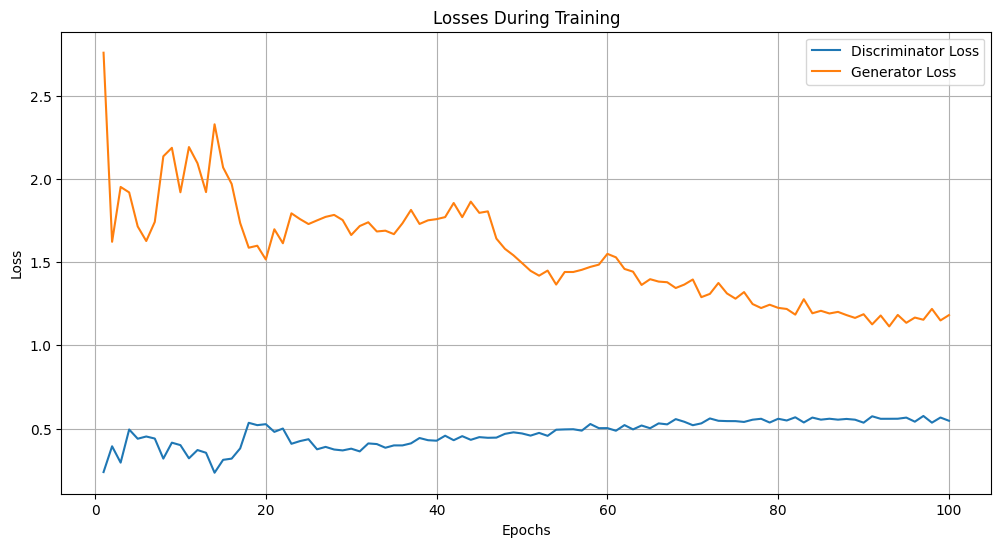

In [ ]:
# Extract the losses during training
dis_losses = cgan_hist.history["d_loss"]
gen_losses = cgan_hist.history["g_loss"]
epochs = range(1, len(dis_losses) + 1)

# Plot the history of losses
### --YOUR CODE HERE-- ###
plt.figure(figsize=(12, 6))
plt.plot(epochs, dis_losses, label='Discriminator Loss')
plt.plot(epochs, gen_losses, label='Generator Loss')
plt.title('Losses During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

7. Generate at least ten (10) images by feeding the generator network with a 128-dimensional noise and one-hot encoded labels. Use a different encoded label for each image. How many of these images resemble the desired dataset label? Document the labels used for each generated images and write your observations in the final report.

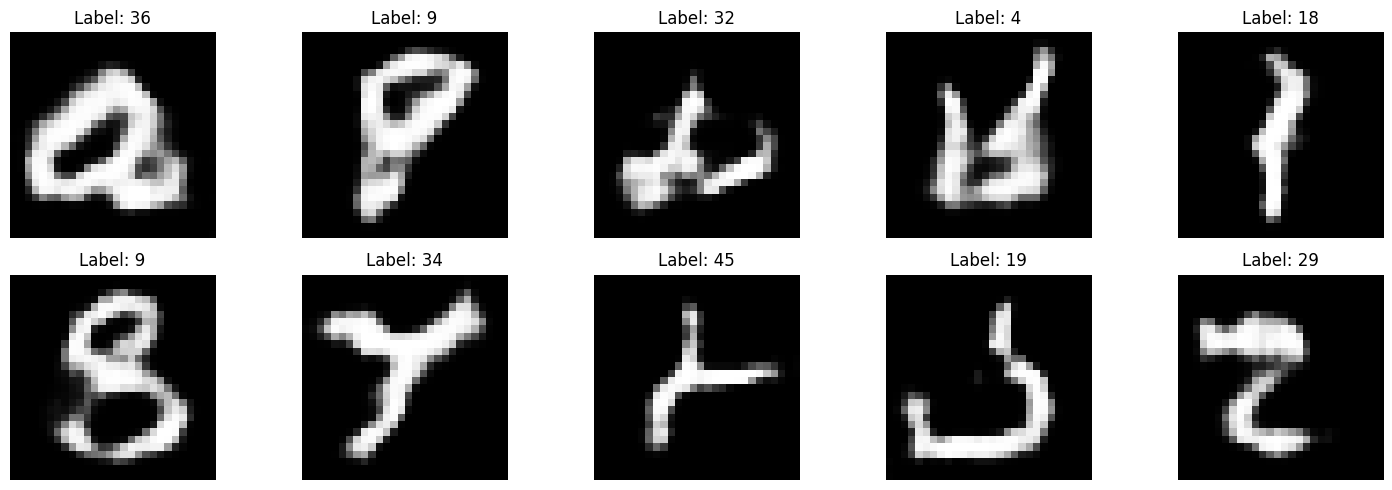

In [ ]:
# Import functions and classes from Keras library
from keras.random import normal, randint

# Generate 10 random 128-dimensional vectors as input
# Select 10 random labels from the dataset
# Feed the random inputs to the generator network
# Display the output images of the generator
### --YOUR CODE HERE-- ###

num_images = 10
random_latent_vectors = normal(shape=(num_images, 128), seed=cgan.seed_generator)
random_labels = np.random.randint(0, num_classes, size=(num_images,))
one_hot_labels = to_categorical(random_labels, num_classes)

random_vector_labels = np.concatenate([random_latent_vectors, one_hot_labels], axis=1)
generated_images = cgan.generator(random_vector_labels)


plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.title(f'Label: {random_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

8. Training GANs comes with various challenges. Thus, you may have to tweak your model to be able to come up with good results. If the results in Step A.7 is not satisfactory, do a research and apply various techniques to improve the results. You may refer to this link for some tips and tricks: [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks). Document the process in your final report.

In [ ]:
### --YOUR CODE HERE-- ###


**B. Image Super-Resolution using SRGAN**

1. Acquire and preprocess the [DIV2K Dataset](https://data.vision.ee.ethz.ch/cvl/DIV2K/). Use the bicubic_x8 data. Display at least ten (10) images. Execute the next code cell to define the model parameters.

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_x8.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x8/incomplete.TCSCYN_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x8/incomplete.TCSCYN_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x8/2.0.0. Subsequent calls will reuse this data.


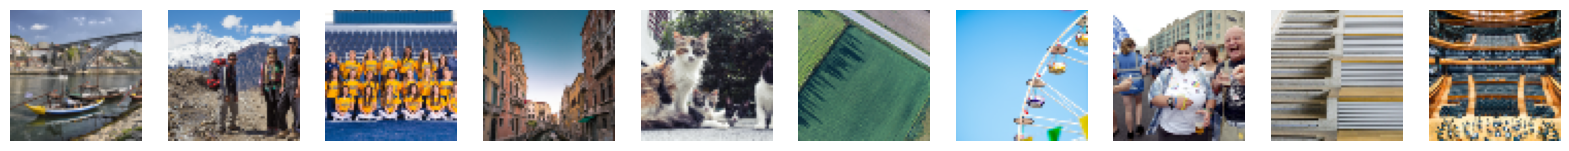

In [ ]:
# Load the DIV2K dataset
# https://www.tensorflow.org/datasets/catalog/div2k
# Save the train dataset to variable ds_train
# Save the validation dataset to variable ds_val
# Save the dataset info to variable ds_info
# The dataset has to be in Tensorflow Dataset format
# Define image sizes
lr_size, hr_size = 64, 256
### --YOUR CODE HERE-- ###
dataset, ds_info = tfds.load(
    "div2k/bicubic_x8",
    split=["train", "validation"],
    as_supervised=True,
    with_info=True
)

ds_train = dataset[0]
ds_val = dataset[1]

# Define the preprocessing function
# Resize the low resulution image to a size of 64 x 64 pixels
# Resize the high resulution image to a size of 256 x 256 pixels
# Maintain aspect ratio. Cropping may be necessary
# The image should not contain zero padding
# Normalize the pixel values of all images
# Apply image preprocessing to the datasets
from keras.preprocessing.image import smart_resize

### --YOUR CODE HERE-- ###
def preprocess(lr_img, hr_img):
  lr_img = smart_resize(lr_img, (lr_size, lr_size), interpolation='bilinear')
  hr_img = smart_resize(hr_img, (hr_size, hr_size), interpolation='bilinear')
  lr_img = tf.cast(lr_img, tf.float32) / 255.0
  hr_img = tf.cast(hr_img, tf.float32) / 255.0
  return lr_img, hr_img

ds_train = ds_train.map(preprocess)
ds_val = ds_val.map(preprocess)

# Display 10 low resolution images from the train dataset in a single row
### --YOUR CODE HERE-- ###
plt.figure(figsize=(20, 2))
for i, (lr_img, hr_img) in enumerate(ds_train.take(10)):
  plt.subplot(1, 10, i + 1)
  plt.imshow(lr_img)
  plt.axis('off')
plt.show()


In [ ]:
# Define the model paramaters
lr_input_shape = (lr_size, lr_size, 3)
hr_input_shape = (hr_size, hr_size, 3)
num_channels = 3
num_residual_block = 4
num_upscale_block = 2

print(hr_input_shape)

(256, 256, 3)


2. Build the generator network as found in the example [here](https://drive.google.com/file/d/11lyvcf3NXB7lhbNh6RQ5RU6pzNowZCPq/view?usp=drive_link).

In [ ]:
# Import functions and classes from Keras library
from keras import Model, Input
from keras.layers import PReLU
from keras.layers import Conv2D, BatchNormalization, UpSampling2D, add

# Define the residual block
def residual_block(input):
    residual_layer = Conv2D(64, (3, 3), padding="same")(input)
    residual_layer = BatchNormalization(momentum=0.5)(residual_layer)
    residual_layer = PReLU(shared_axes=[1, 2])(residual_layer)
    residual_layer = Conv2D(64, (3, 3), padding="same")(residual_layer)
    residual_layer = BatchNormalization(momentum=0.5)(residual_layer)
    return add([input, residual_layer])

# Define the upscaling block
def upscale_block(input):
    upscale_layer = Conv2D(256, (3, 3), padding="same")(input)
    upscale_layer = UpSampling2D(size=2)(upscale_layer)
    return PReLU(shared_axes=[1,2])(upscale_layer)

# Create the generator network layers from the illustrated model plot
# Save the input layer to gen_input variable. Use low resolution shape
# There are 4 residual blocks. You can use loops to generate them
# There are 2 upscaling blocks. You can also use loops to generate them
# Save the last layer output to gen_output variable
### --YOUR CODE HERE-- ###
gen_input = Input(shape=lr_input_shape, name="input_layer_1")
x = Conv2D(64, (3, 3), padding="same")(gen_input)
x = PReLU(shared_axes=[1, 2], name="PReLU_1")(x)
prelu2 = x

for i in range(num_residual_block):
    x = residual_block(x)

x = Conv2D(64, (3, 3), padding="same", name="conv2d_22")(x)
x = BatchNormalization(momentum=0.5, name="batch_normalization_22")(x) #momentum=0.5,
x = add([x, prelu2])

for i in range(num_upscale_block):
    x = upscale_block(x)

gen_output = Conv2D(3, (3, 3), padding="same", name="conv2d_25", activation='tanh')(x)

# Create the generator network using the layers defined above
srgan_generator = Model(gen_input, gen_output, name="generator")
srgan_generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer_1 (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1792      ['input_layer_1[0][0]']       
                                                                                                  
 PReLU_1 (PReLU)             (None, 64, 64, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['PReLU_1[0][0]']             
                                                                                          

3. Build the discriminator network as found [here](https://drive.google.com/file/d/1bhqaB2Oj6VJiI3m38RWsQZEtbZhlpLFw/view?usp=drive_link).

In [ ]:
# Import functions and classes from Keras library
from keras import Model, Input
from keras.layers import LeakyReLU, Dense, Flatten
from keras.layers import Conv2D, BatchNormalization

# Define the discriminator subblock
def discriminator_subblock(input, filters, strides=1):
  dis_layer = Conv2D(filters, (3, 3), strides=strides,
                      padding="same")(input)
  dis_layer = BatchNormalization(momentum=0.8)(dis_layer)
  return LeakyReLU(alpha=0.2)(dis_layer)

# Create the discriminator network layers from the illustrated model plot
# Save the input layer to dis_input variable. Use high resolution shape
# Save the last layer output to dis_output variable
### --YOUR CODE HERE-- ###

dis_input = Input(shape=hr_input_shape, name="input_layer_1")
x = Conv2D(64, (3, 3), padding="same", name="conv2d_37", activation='linear')(dis_input)
x = LeakyReLU(alpha = 0.2)(x)

x = discriminator_subblock(x, 64, strides=2)
x = discriminator_subblock(x, 128, strides=1)
x = discriminator_subblock(x, 128, strides=2)
x = discriminator_subblock(x, 256, strides=1)
x = discriminator_subblock(x, 256, strides=2)
x = discriminator_subblock(x, 512, strides=1)

x = Flatten()(x)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.2)(x)
dis_output = Dense(1, activation='sigmoid')(x)
# Create the discriminator network using the layers defined above
srgan_discriminator = Model(dis_input, dis_output, name="discriminator")

srgan_discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer_1 (InputLayer)  [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_8 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                     

4. Execute the code below that will define a custom model for Super-Resolution GAN. The code will also load the pre-trained VGG19 model for computing the feature-based loss.

In [ ]:
print(srgan_discriminator.input_shape)

(None, 256, 256, 3)


In [ ]:
# Import the pretrained VGG19 model up to the 10th layer
# This will be used to extract the features of high resolution image
from keras.applications import VGG19

vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_input_shape)
vgg = Model(vgg.input, vgg.layers[10].output, name="vgg")
vgg.trainable = False

# Create the SRGAN model
srgan_input = Input(shape=lr_input_shape)
gen_output = srgan_generator(srgan_input)
dis_output = srgan_discriminator(gen_output)
gen_features = vgg(gen_output)
srgan_discriminator.trainable = False

# Instantiate the SRGAN model
srgan = Model(srgan_input, [dis_output, gen_features], name="srgan")

80134624/80134624 [==============================] - 0s 0us/step


5. Configure the network for training. Then train the model with a batch size of your choice. Make sure to save the history of losses per training epoch.

In [ ]:
# Configure the discriminator for training
srgan_discriminator.compile(loss="binary_crossentropy", optimizer="adam")

# Configure the SRGAN for training
srgan.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1],
              optimizer="adam")

# Define batch size and number of epochs
# Save the batch size to batch_size variable
# Save the number of epochs to num_epochs variable
### --YOUR CODE HERE-- ###

batch_size = 10
num_epochs = 10

# Create a shuffled batch of the training dataset
ds_shuffled_batch = ds_train.shuffle(100)
ds_shuffled_batch = ds_shuffled_batch.batch(batch_size)

# Define the history of losses per epoch
dis_loss, gen_loss = [], []

# Train the network
for epoch in range(num_epochs):
  print(f"Epoch {epoch + 1}/{num_epochs}")

  # Define the labels
  gen_label = np.zeros((batch_size, 1))
  real_label = np.ones((batch_size, 1))

  # Define history of losses per batch
  dis_loss_batch, gen_loss_batch = [], []

  for lr_imgs, hr_imgs in ds_shuffled_batch:
    # Get generated images
    gen_imgs = srgan_generator.predict_on_batch(lr_imgs)

    # Unfreeze discriminator weights for training
    srgan_discriminator.trainable = True

    # Train the discriminator
    dis_loss_gen = srgan_discriminator.train_on_batch(gen_imgs, gen_label)
    dis_loss_real = srgan_discriminator.train_on_batch(hr_imgs, real_label)

    # Freeze discriminator weights
    srgan_discriminator.trainable = False

    # Compute the discriminator loss
    d_loss = 0.5 * np.add(dis_loss_gen, dis_loss_real)
    dis_loss_batch.append(d_loss)

    # Obtain image features
    hr_features = vgg.predict_on_batch(hr_imgs)

    # Train the generator
    g_loss = srgan.train_on_batch(lr_imgs, [real_label, hr_features])
    gen_loss_batch.append(g_loss[0])

    print(".", end="")

  # Save the losses
  dis_loss.append(np.mean(dis_loss_batch))
  gen_loss.append(np.mean(gen_loss_batch))

  print(f"d_loss: {dis_loss[-1]} - g_loss: {gen_loss[-1]}")

Epoch 1/10
................................................................................d_loss: 0.693186104670167 - g_loss: 96.46188182830811
Epoch 2/10
................................................................................d_loss: 0.6932609871029853 - g_loss: 76.61480407714843
Epoch 3/10
................................................................................d_loss: 0.6933708887547254 - g_loss: 68.82337284088135
Epoch 4/10
................................................................................d_loss: 0.6933976419270038 - g_loss: 46.79679675102234
Epoch 5/10
................................................................................d_loss: 0.693301847949624 - g_loss: 39.43370399475098
Epoch 6/10
................................................................................d_loss: 0.69324353300035 - g_loss: 37.906379866600034
Epoch 7/10
................................................................................d_loss: 0.6932124383747578 - g_loss:

6. Plot the generator and discriminator losses per epoch. Place appropriate plot title and axis labels.

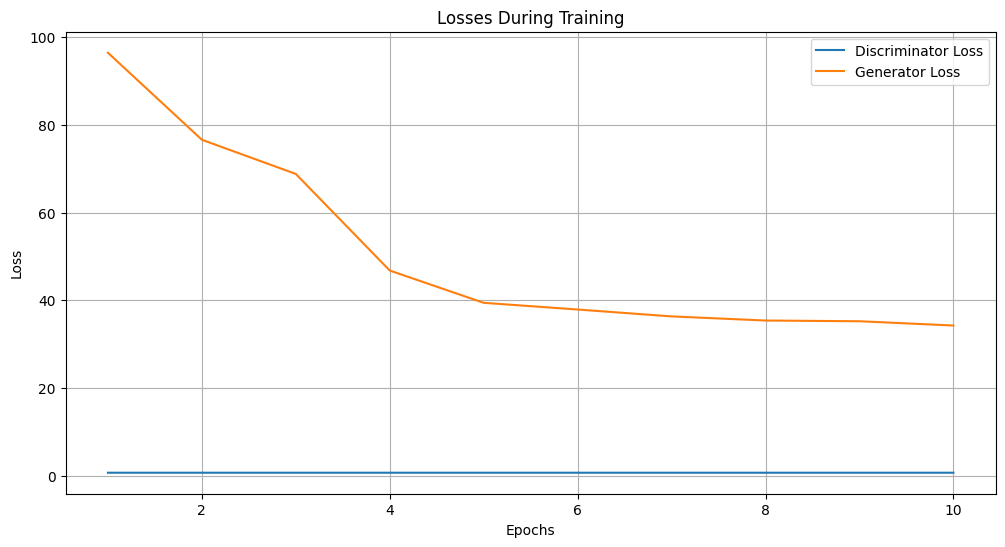

In [ ]:
# Extract the losses during training
### --YOUR CODE HERE-- ###
epochs = range(1, num_epochs + 1)

# Plot the history of losses
### --YOUR CODE HERE-- ###
plt.figure(figsize=(12, 6))
plt.plot(epochs, dis_loss, label='Discriminator Loss')
plt.plot(epochs, gen_loss, label='Generator Loss')
plt.title('Losses During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


7. Obtain the output for at least ten (10) low resolution images from the validation dataset. Display both the generated high resolution image and the corresponding high resolution image. How many of these outputs resemble the original image? Write your observations in your final report.

1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 103ms/step


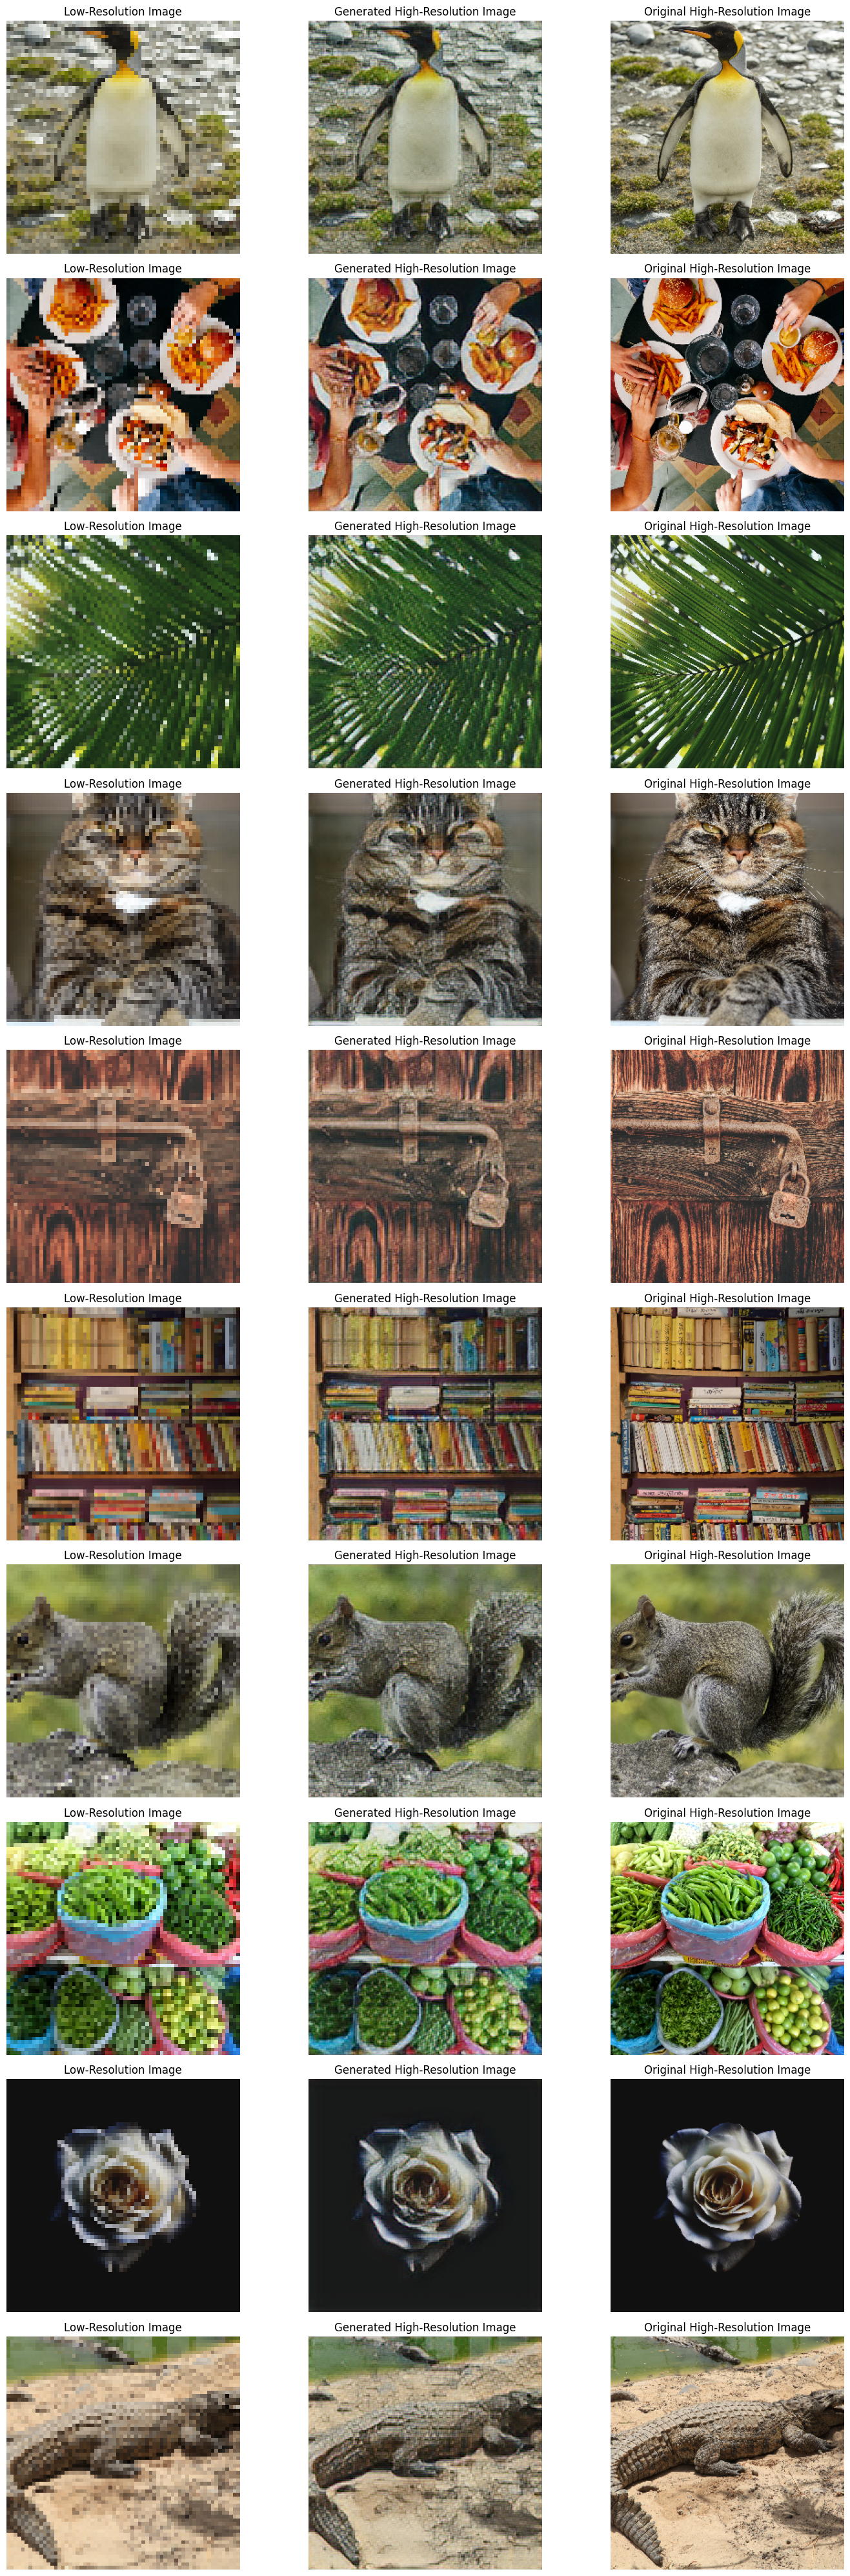

In [ ]:
### --YOUR CODE HERE-- ###
ds_val_take10 = ds_val.take(10)

fig, axes = plt.subplots(10, 3, figsize=(15, 40))

for i, (lr_img, hr_img) in enumerate(ds_val_take10):
    gen_img = srgan_generator.predict(tf.expand_dims(lr_img, axis=0))[0]
    axes[i, 0].imshow(lr_img)
    axes[i, 0].set_title('Low-Resolution Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(gen_img)
    axes[i, 1].set_title('Generated High-Resolution Image')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(hr_img)
    axes[i, 2].set_title('Original High-Resolution Image')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

8. Training GANs comes with various challenges. Thus, you may have to tweak your model to be able to come up with good results. If the results in Step B.7 is not satisfactory, do a research and apply various techniques to improve the results. You may refer to this link for some tips and tricks: [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks). Document the process in your final report.

In [ ]:
### --YOUR CODE HERE-- ###


***

### Machine Problems


### References

[1] Mirza, M., & Osindero, S. (2014). *Conditional Generative Adversarial Nets*. https://arxiv.org/abs/1411.1784v1

[2] Ledig, C., Theis, L., Huszár, F., Caballero, J., Cunningham, A., Acosta, A., Aitken, A., Tejani, A., Totz, J., Wang, Z., & Shi, W. (2016). *Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network*. Proceedings - 30th IEEE Conference on Computer Vision and Pattern Recognition, CVPR 2017, 2017-January, 105–114. https://doi.org/10.1109/CVPR.2017.19

[3] Aggarwal, Charu C. *Neural Networks and Deep Learning : A Textbook*. 2nd ed. Cham: Springer International Publishing, 2023.

[4] I. Goodfellow, Y. Bengio and A. Courville, *Deep Learning*. MIT Press, 2016.

[5] *Keras 3 API documentation*. https://keras.io/api/

[6] *EMNIST Dataset*. https://www.nist.gov/itl/products-and-services/emnist-dataset

[7] *DIV2K Dataset*. https://data.vision.ee.ethz.ch/cvl/DIV2K/